## 1 Overview
An enviroment to train and evaluate neural networks on learning logical consequence. 

In [ ]:
# For google collab
!git clone https://github.com/stereifberger/master-s-thesis
%cd master-s-thesis/

In [1]:
%cd master-s-thesis/

/home/str/master-s-thesis


/home/str/environments/general/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# Install required dependencies - not necessary on google colab
!pip install -r requirements.txt

In [131]:
# Import required libraries
from imports import *

In [132]:
importlib.reload(calculi)

<module 'calculi' from '/home/str/master-s-thesis/calculi.py'>

## 2 Create dataset
First the dataset for training is generated. For this the function "create_dataset" from "generation.py" utilizes the functions "gen_outp_PA" to generate a set of random starting formulas, for which iterativly the applicability of rules is checked. All applicable rules are then used to generate new derivations. In each iteration of gen_oupt_PA, set by the iterations variable, new, longer examples are generated.

**Rules.** The rules are defined in calculi.py. Two sets are avaiable: Intuitionistic propositional logic (set below via "calculus = ipl") and classical propositional logic (set below via "calculus = cpl").

**Dataset entries.**
- **x_train.** Training input: [INDEX, PREMISES, DERIVATION SYMBOL, CONCLUSION]
- **y_train_ordered.** Dataset of correct derivations where each sublist i correspnds to INDEX: [DERIVATIONS_0...DERIVATION_N]

**Encoding.** Propositional variables and logical constants are encoded as integers. The integers are then one-hot-encoded into unique sequences containing only 0s and ones with the length of the maximum integer value, the feature length. The shape of the individual entries is 2D: [SEQUENCE LENGTH, FEATURE LENGTH].

**Example entries withouth numerical representation and one-hot-encoding.**
- **x_train.** [2345, A, A THEN B, DERIVES, B OR C]
- **y_train_ordered.** Sublist 2345 is entry entry: [[A, A THEN B, B, B OR C], [A, A THEN B, B, A AND B, B OR C]]


In [171]:
# Create dataset
x_train_2d, x_train_3d, y_train_ordered, max_y_train_len = generation.create_dataset(iterations = [1,2], calculus = calculi.ipl)

Processed at iteration 1:   0%|          | 0/500 [00:00<?, ?it/s]

Processed at iteration 2:   0%|          | 0/2808 [00:00<?, ?it/s]

Processed premises for sample conclusions at iteration 2:   0%|          | 0/3343 [00:00<?, ?it/s]

Checked derivations for sample conclusions:   0%|          | 0/40002 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/24113 [00:00<?, ?it/s]

  0%|          | 0/24113 [00:00<?, ?it/s]

Processed entries for x_train and y_tdict:   0%|          | 0/24113 [00:00<?, ?it/s]

Padded y_train_ordered:   0%|          | 0/11315 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/11315 [00:00<?, ?it/s]

LENINPT: 11315
LENy_t: 11315
Number x_train examples: 11315
Average number ground truth examples/x_train example: 2.131064958020327


## 3 Prepare dataset and define model for training
Next with pytorch's dataloader the single training entries in x_train are assigned to batches of size "batch size" in mixed order. Then the different models are defined using definitions from "architectures.py". These models are:

- Feedforward network (net)
- Recurrent neural network (RNNNet)
- Long-short-term memory (LSTMNet)
- Transformers (TransformerModel)

In [172]:
# Use when gpu is present to empty its catch and define it as "device" for referencing it
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [173]:
# Get the datasets' shapes for th model definitions later
two_d_shape = x_train_2d.shape
three_d_shape = x_train_3d.shape

In [174]:
# Set train-test split to 80-20 and get the 2d dataset's shapes # [^1]
train_size = int(0.8 * len(x_train_2d)) 
test_size = len(x_train_2d) - train_size 
x_train_2d, x_test_2d = random_split(x_train_2d, [train_size, test_size])
train_size = int(0.8 * len(x_train_3d))
test_size = len(x_train_3d) - train_size
x_train_3d, x_test_3d = random_split(x_train_3d, [train_size, test_size])

In [175]:
# Collect and mix the data in [^2]
train_dataloader_2d = DataLoader(dataset = x_train_2d, shuffle = True, batch_size = 50)
test_dataloader_2d = DataLoader(dataset = x_test_2d, shuffle = True, batch_size = 50)
train_dataloader_3d = DataLoader(dataset = x_train_3d, shuffle = True, batch_size = 50)
test_dataloader_3d = DataLoader(dataset = x_test_3d, shuffle = True, batch_size = 50)

In [273]:
# Define the four models [^3]
ffn_model = architectures.ffn(input_size = two_d_shape[1]-1, 
                              hidden_size = 20,
                              output_size = max_y_train_len)
rnn_model = architectures.rnn(input_size = three_d_shape[2],
                              hidden_size = 120,
                              output_size = max_y_train_len)
lst_model = architectures.lst(input_size = three_d_shape[2],
                              hidden_size = 20,
                              output_size = max_y_train_len)
tra_model = architectures.tra(input_size = three_d_shape[2],
                              hidden_size = 20,
                              output_size = max_y_train_len,
                              num_layers = 10,
                              nhead = 4)

/home/str/environments/general/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [231]:
# Define the optimizer to be SGD, with a learning rate of 0.1 [^4]
ffn_optimizer = torch.optim.SGD(ffn_model.parameters(),lr=0.100)
rnn_optimizer = torch.optim.SGD(rnn_model.parameters(),lr=0.100)
lst_optimizer = torch.optim.SGD(lst_model.parameters(),lr=0.100)
tra_optimizer = torch.optim.SGD(tra_model.parameters(),lr=0.100)

# Train for 1000 epochs
epochs = 50

## 4 Training
Each subsequent cell trains one of the four models and calculates their mean squared error loss for the nearest correct derivation from the dataset to the derivation provided by the model. The logic for this is impolemented in the custom loss function "mse_min_dist" in losses.py.

In [194]:
# Load the feedforward model to the gpu 
ffn_model.to(device)

ffn(
  (l1): Linear(in_features=756, out_features=20, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=20, out_features=1008, bias=True)
)

In [232]:
# Load the ground truth data to the gpu
y_train = y_train_ordered.to(device)

In [233]:
max_y_length = int(max_y_train_len/14)

In [227]:
importlib.reload(losses)

<module 'losses' from '/home/str/master-s-thesis/losses.py'>

In [198]:
#GPT TEST
import torch
import torch.nn as nn

def nffn_mse_min_dist(y_pred, x_train, outp_dict, max_y_train_len):
    # Assuming each entry in y_pred corresponds to a set in outp_dict directly by index
    batch_losses = []
    model_output_list = []
    ground_truth_list = []

    for idx, (y_pred_single, x_train_single) in enumerate(zip(y_pred, x_train)):
        y_train_set = outp_dict[int(x_train_single[0])]  # Assuming this indexing is valid and returns a tensor

        # If y_train_set is empty, continue to next
        if y_train_set.nelement() == 0:
            continue
        
        # Filter out zero lists
        non_zero_mask = torch.any(y_train_set != 0, dim=1)
        y_train_set = y_train_set[non_zero_mask]

        # Expand y_pred_single for distance calculation
        y_pred_single_expanded = y_pred_single.unsqueeze(0).expand_as(y_train_set)
        distances = torch.norm(y_train_set - y_pred_single_expanded, dim=1)  # Euclidean distance

        # Select the relevant y_train instance based on minimum distance
        min_distance, min_idx = torch.min(distances, dim=0)  # Find minimal distance
        selected_y_train = y_train_set[min_idx]

        ground_truth_list.append(selected_y_train)
        model_output_list.append(y_pred_single)

    if not model_output_list:  # Handle case when model_output_list is empty
        return torch.tensor(0.0, requires_grad=True)

    model_output_batch = torch.stack(model_output_list)
    ground_truth_batch = torch.stack(ground_truth_list)

    # Convert ground_truth_batch to class indices if necessary
    if ground_truth_batch.dim() == 2 and ground_truth_batch.size(1) > 1:  # Check if targets are one-hot encoded
        ground_truth_batch = torch.argmax(ground_truth_batch, dim=1)
    else:
        ground_truth_batch = ground_truth_batch.long()

    criterion = nn.CrossEntropyLoss()
    loss = criterion(model_output_batch, ground_truth_batch) 

    return loss


In [ ]:
### FFN ### [^5]
ffn_costval_train = [] # Define the lists for the loss values
ffn_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    ffn_model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_2d):   # Loop over all batches
        x_train = x_train.to(device)
        y_pred = ffn_model(x_train[:,1:])               # Get the model's output for batch
        cost = losses.nffn_mse_min_dist(y_pred, x_train, y_train, max_y_length) # Calculate loss
        # Backpropagation
        ffn_optimizer.zero_grad()
        cost.backward()
        ffn_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_2d) # Calculate average loss
    ffn_costval_train.append(avg_train_loss)

    ffn_model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0
    # Analog to above but without training a loop over all batches
    with torch.no_grad():
        for i, x_test in enumerate(test_dataloader_2d):
            x_test = x_test.to(device)
            y_pred = ffn_model(x_test[:, 1:])
            cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    ffn_costval_test.append(avg_train_loss)

    if j % 2 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

In [19]:
from torch import Tensor

<module 'losses' from '/home/str/master-s-thesis/losses.py'>

In [216]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_2d):
        x_test = x_test.to(device)
        y_pred = ffn_model(x_test[:, 1:])
        decoded = []
        decoded_part = []
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            pred = Tensor.cpu(pred)
            test = Tensor.cpu(test)
            pred = np.argmax(pred, axis=1) 
            test = np.argmax(test, axis=1) 
            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1
        cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
        test_loss += cost.item()
avg_test_loss = test_loss / len(test_dataloader_2d)
ffn_costval_test.append(avg_train_loss)

INPUT: (q(r∧p))⊢(q∧r)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: ((s∨p)t)⊢(t∨p)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: ((s∧t)(p→(t→t)))⊢(r∨(p→(t→t)))
OUTPUT: ((→(()s))((s∨((())((∨)))
INPUT: ((t∨t)((q∨r)∧t))⊢(((q∨r)∧t)∧(q∨r))
OUTPUT: ((→(()s)))((∨((())()∨)))
INPUT: (t(t→q))⊢(s∨(t→(t→q)))
OUTPUT: ((∧→))()))((∨()(∨∨)))
INPUT: (s(s∧t))⊢((s∧t)→t)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: (p((p∨q)∨q))⊢(t∨p)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: (((r∧q)→t)((p∨p)→s))⊢(((r∧q)→t)→(t∨((r∧q)→t)))
OUTPUT: ((→((∨∨))((s)((())((∨))(())))((((∨(())))))
INPUT: ((r∧q)p)⊢(p→r)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: ((t∧q)(q∨p))⊢((q∨p)∨r)
OUTPUT: ((∧∧))(())((∨))(∨∨))
INPUT: (q(q∧p))⊢(p∨p)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: (((s∨p)→s)(q∧r))⊢(t∨((s∨p)→s))
OUTPUT: ((→((∨∨))((s∨((())((∨)))))
INPUT: ((¬q)(r∧p))⊢((¬q)∨q)
OUTPUT: ((∧∧))(())((∨))()
INPUT: ((¬p)r)⊢(r∨r)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: (p(r→t))⊢((p∨p)∨t)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: ((s∧r)q)⊢(p∨(s∧r))
OUTPUT: ((∧∧))((∨))(∨)
INPUT: (q(t→(t∧p)))⊢(r∨q)
OUTPUT: ((∧∧))((∨))(∨)
INPUT: ((s→(¬r))p)⊢(p∨q)
OUTPUT: (

In [274]:
rnn_model.to(device)

rnn(
  (rnn): RNN(14, 120, batch_first=True)
  (fc): Linear(in_features=120, out_features=1008, bias=True)
)

In [251]:
importlib.reload(losses)

<module 'losses' from '/home/str/master-s-thesis/losses.py'>

In [275]:
### RNN ###
rnn_costval_train = [] # Define the lists for the loss values
rnn_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    rnn_model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_3d):   # Loop over all batches
        x_train = x_train.to(device)
        y_pred = rnn_model(x_train[:,1:])               # Get the model's output for batch 
        cost = losses.threed_mse_min_dist(y_pred, x_train, y_train, max_y_length) # Calculate loss
        # Backpropagation
        rnn_optimizer.zero_grad()
        cost.backward()
        rnn_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_3d) # Calculate average loss
    rnn_costval_train.append(avg_train_loss)

    rnn_model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0 
    # Analog to above but without training a loop over all batches
    with torch.no_grad(): 
        for i, x_test in enumerate(test_dataloader_3d):
            x_test = x_test.to(device)
            y_pred = rnn_model(x_test[:, 1:])
            cost = losses.threed_mse_min_dist(y_pred, x_test, y_train, max_y_length)
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    rnn_costval_test.append(avg_train_loss)

    if j % 1 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Train Loss - 497.9571414151035, Test Loss - 497.9356915017833
Epoch 1: Train Loss - 497.9529987377125, Test Loss - 497.9353305982507
Epoch 2: Train Loss - 497.9562235402537, Test Loss - 497.9335420028023
Epoch 3: Train Loss - 497.9539821750515, Test Loss - 497.9361227284307
Epoch 4: Train Loss - 497.9530243925996, Test Loss - 497.9395950980808


KeyboardInterrupt: 

In [276]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = rnn_model(x_test[:, 1:])
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            pred = Tensor.cpu(pred)
            test = Tensor.cpu(test)
            pred = np.argmax(pred, axis=1) 
            test = np.argmax(test, axis=1) 
            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1

INPUT: ((p→(r→p))q)⊢((q∨r)∨q)
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: (((t∨r)∧t)p)⊢(((t∨r)∧t)∧(((t∨r)∧t)∨q))
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: ((r→q)t)⊢(t∨t)
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: ((s→t)(p∧t))⊢((p∧t)→t)
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: (s(s∧t))⊢(s∧(r∨s))
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: (((r∧q)∨q)s)⊢(((r∧q)∨q)∨r)
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: ((t∧p)q)⊢((t∧p)∨t)
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: ((¬r)(¬t))⊢((¬t)∨t)
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: ((s∨p)t)⊢(t∨(s∨p))
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INPUT: (q(q→(p→p)))⊢(q∧(q∨p))
OUTPUT: ¬⊥→¬r¬)(t⊢⊥q(tt⊥→⊥))⊥⊢r∧rs¬p∨tp⊢s→s∧∧⊥)s¬→¬∧)¬⊢∨p⊢⊥⊥⊢→¬¬¬)qtq
INP

In [257]:
lst_model.to(device)

lst(
  (lstm): LSTM(14, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1008, bias=True)
)

In [259]:
### LSTM ###
lst_costval_train = [] # Define the lists for the loss values
lst_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    lst_model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_3d):   # Loop over all batches
        x_train = x_train.to(device)
        y_pred = lst_model(x_train[:,1:])               # Get the model's output for batch 
        cost = losses.threed_mse_min_dist(y_pred, x_train, y_train, max_y_length) # Calculate loss
        # Backpropagation
        lst_optimizer.zero_grad()
        cost.backward()
        lst_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_3d) # Calculate average loss
    lst_costval_train.append(avg_train_loss)

    lst_model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0 
    # Analog to above but without training a loop over all batches
    with torch.no_grad(): 
        for i, x_test in enumerate(test_dataloader_3d):
            x_test = x_test.to(device)
            y_pred = lst_model(x_test[:, 1:])
            cost = losses.threed_mse_min_dist(y_pred, x_test, y_train, max_y_length)
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    lst_costval_test.append(avg_train_loss)

    if j % 1 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Train Loss - 497.92333045372595, Test Loss - 497.9182022758152
Epoch 1: Train Loss - 497.929692195012, Test Loss - 497.91761779785156
Epoch 2: Train Loss - 497.93067328484506, Test Loss - 497.9236596148947


KeyboardInterrupt: 

In [65]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = lst_model(x_test[:, 1:])
        print(y_pred.shape)
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            pred = Tensor.cpu(pred)
            test = Tensor.cpu(test)
            pred = np.argmax(pred, axis=1) 
            test = np.argmax(test, axis=1) 
            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1
        cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
        test_loss += cost.item()
avg_test_loss = test_loss / len(test_dataloader_2d)
ffn_costval_test.append(avg_train_loss)

torch.Size([50, 1008])
INPUT: (((t∧r)∨t)(r→t))⊢((r→t)∧(((t∧r)∨t)→(r→t)))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((t∨r)s)⊢(s∨(t∨r))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (((¬t)∧s)((s∨p)∨t))⊢s
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (s(s→(r∧r)))⊢(p∨(s∨p))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((q→s)p)⊢(p∨q)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(s→(q∨t)))⊢(q∨(r∨r))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((t∧(s∧q))t)⊢(t∨s)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((¬p)q)⊢q
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((r∨q)q)⊢(r∨q)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r((p→s)∨t))⊢(r∨p)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(t→(t∧q)))⊢(r∨t)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((q→q)(p∧q))⊢((q→q)∨s)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(¬p))⊢r
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (q(r→(q∧q)))⊢q
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (((t∧s)∧q)t)⊢(p∨(t∨q))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((t∨r)(q→p))⊢(t∨(t∨r))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(p∨t))⊢((p∨t)∨r)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (p(q∧s))⊢((q∧s)∧q)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((p∧(q→p))p)⊢(p→(s∨p))
OUTPUT: ((∨∧

ValueError: only one element tensors can be converted to Python scalars

In [265]:
tra_model.to(device)

tra(
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder): Linear(in_features=14, out_features=20, bias=True)
  (decoder): Linear(in_features=20, out_features=1008, bias=True)
)

In [268]:
### Transformer ###
tra_costval_train = [] # Define the lists for the loss values
tra_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    tra_model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_3d):   # Loop over all batches
        x_train = x_train.to(device)
        y_pred = tra_model(x_train[:,1:])               # Get the model's output for batch 
        cost = losses.threed_mse_min_dist(y_pred, x_train, y_train, (max_y_train_len/14)) # Calculate loss
        # Backpropagation
        tra_optimizer.zero_grad()
        cost.backward()
        tra_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_3d) # Calculate average loss
    tra_costval_train.append(avg_train_loss)

    tra_model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0 
    # Analog to above but without training a loop over all batches
    with torch.no_grad(): 
        for i, x_test in enumerate(test_dataloader_3d):
            x_test = x_test.to(device)
            y_pred = tra_model(x_test[:, 1:])
            cost = losses.threed_mse_min_dist(y_pred, x_test, y_train, (max_y_train_len/14))
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    tra_costval_test.append(avg_test_loss)

    if j % 1 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: expand(torch.cuda.FloatTensor{[1, 54, 1008]}, size=[1, 1008]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [68]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = tra_model(x_test[:, 1:])
        print(y_pred.shape)
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            pred = Tensor.cpu(pred)
            test = Tensor.cpu(test)
            pred = np.argmax(pred, axis=1) 
            test = np.argmax(test, axis=1) 
            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1
        cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
        test_loss += cost.item()
avg_test_loss = test_loss / len(test_dataloader_2d)
ffn_costval_test.append(avg_train_loss)

torch.Size([50, 54, 1008])
INPUT: (q(r→(q∧q)))⊢q
OUTPUT: ((∧∧))(())((∨))(()))((∨∧))(())((∨()(((()((∧r)((())((∨)(((∨(())((sq)((())((∨()((t)))((r())(())((()((t)))((∧∧))(())(()))((∨))((→)))()))((p))(())((t())(())(q∨))(())))((∧∧)((())((∨(((())((→∧)((())((∨))((∨))((→∧)((())((∨))((()((→∧))(())((s()(()((r∧))(s))(()()((()((rq))(())((→()((t∨))((→q))(())((()((∨)))((∧∧))(())(((((((∨)((r())(())(())()∧))))((→∨))(())((∨))(()))(((q))(∧))((∨))(∧()))((→q))(())(()()(())((∧()((())((∨()((∨)))((∧())(())((∨))(()))((∧r))(())(()))((∨)))((∧∧))()))((∨))(()))(((r))(())((∨()(()))((∧∧))(())((∨))((()((q()((())((∨((((∨)))((→q))pt))(q∨))(∨)))((∧q)((())((s()((()((∧q))(())((p()(∨)((r∧))(())(()((((∨))((∨())(())((∨))(())))((∨∨))(())(()((((t))((∧()((())((∨()((∨))((∧∧))(())(()(((())((→∧)(()))((q()((())(((∧))(())()∨()((∨)))((→∧))(())(()()(()((→∧))(s))(()()(())(((())(())((∨))(()))((∧q))(())((∨)(((∨)))((→∧))(())((∨))((∨)((→∧))(())(()))(∨))((∧∧)((()((())(((∨()((→q))(())((p(((((((∨q))(())((∨()(()))((→∧)((())((∨))((∨())((→q))(()

ValueError: only one element tensors can be converted to Python scalars

## 5 Plot results
Here all results from above are plotted.

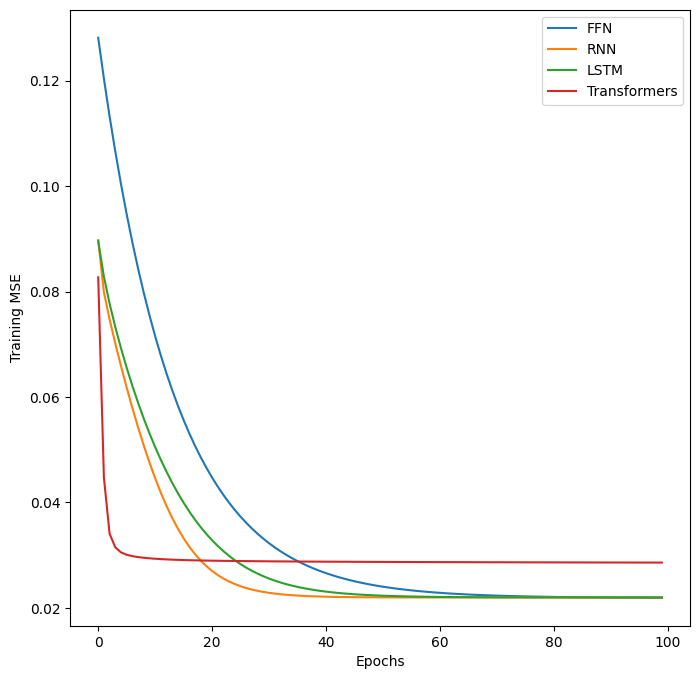

In [32]:
plt.figure(figsize=(8, 8))
x_data = list(range(100))
y_data_ffn = ffn_costval_train
y_data_rnn = rnn_costval_train
y_data_lst = lst_costval_train
y_data_tra = tra_costval_train
plt.plot(x_data, y_data_ffn, label='FFN')
plt.plot(x_data, y_data_rnn, label='RNN')
plt.plot(x_data, y_data_lst, label='LSTM')
plt.plot(x_data, y_data_tra, label='Transformers')
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
plt.legend()
plt.show()

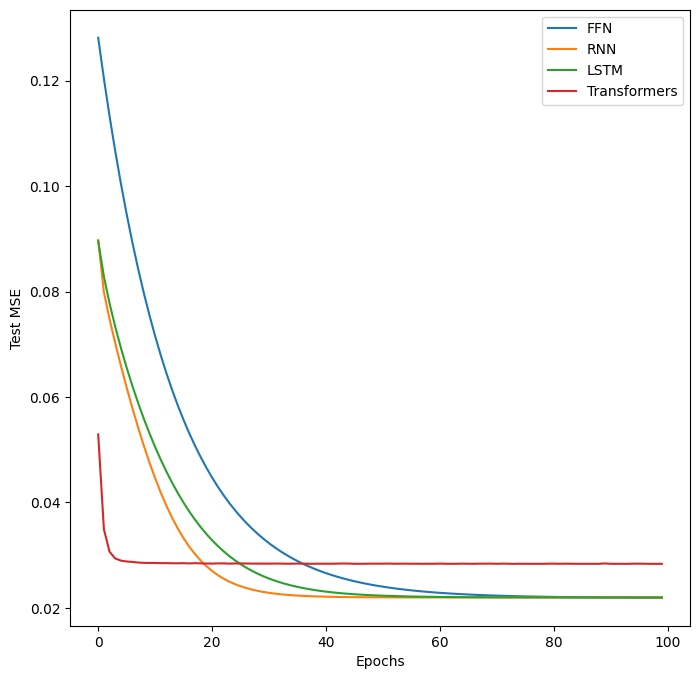

In [33]:
plt.figure(figsize=(8, 8))
x_data = list(range(100))
y_data_ffn = ffn_costval_test
y_data_rnn = rnn_costval_test
y_data_lst = lst_costval_test
y_data_tra = tra_costval_test
plt.plot(x_data, y_data_ffn, label='FFN')
plt.plot(x_data, y_data_rnn, label='RNN')
plt.plot(x_data, y_data_lst, label='LSTM')
plt.plot(x_data, y_data_tra, label='Transformers')
plt.xlabel('Epochs')
plt.ylabel('Test MSE')
plt.legend()
plt.show()